In [1]:
import os
import requests
import pandas as pd
import numpy as np
import scipy
import re
from io import StringIO
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

In [2]:
documentId = "1-IxV9UoncmM1X7LjlGEEmc9PHtqAmnH63Jlv4xTCOp4"
sheetId = 0

# Read data from google spreadsheet

In [3]:
def getSpreadSheet(docId):
    """
    Reads data from google spreadsheet as csv
    
    Inputs
    ======
    docId -- id of the google spreadsheet.  Must be accessible by shared link without authentication.
    
    Outputs
    =======
    csvData -- raw csv data retrieved
    """
    
    requestString = "https://docs.google.com/spreadsheets/d/{DOC_ID}/export?format=csv"
    requestURL = requestString.format(DOC_ID=docId)
    
    requestResult = requests.get(requestURL)
    assert requestResult.status_code == 200 
    csvData = requestResult.content.decode()
    
    return csvData

In [4]:
csvData = getSpreadSheet(documentId)

In [5]:
schema = {"Date" : str,
         "Court" : int,
         "Player1" : str,
          "Player2" : str,
          "Player3" : str,
          "Player4" : str,
          "South" : int,
          "North" : int
         }

def parseCsvData(csvData, schema=None):
    """
    """
    dfData = pd.read_csv(StringIO(csvData), dtype=schema)
    
    return dfData

dfData = parseCsvData(csvData, schema)

In [6]:
def preProcessData(df):
    dfProcessed = df.copy()
    dfProcessed["Date"] = pd.to_datetime(dfProcessed["Date"])
#     dfProcessed["Player1"] = dfProcessed["Player1"].astype(str)

    def cleanName(name):
        cleanedName = name.lower().strip()
        return cleanedName
    
    dfProcessed["Player1"] = dfProcessed["Player1"].apply(cleanName)
    dfProcessed["Player2"] = dfProcessed["Player2"].apply(cleanName)
    dfProcessed["Player3"] = dfProcessed["Player3"].apply(cleanName)
    dfProcessed["Player4"] = dfProcessed["Player4"].apply(cleanName)
    dfProcessed["Score Differential"] = dfProcessed["South"] - dfProcessed["North"]
    dfProcessed["Win"] = dfProcessed["Score Differential"] > 0
    
    return dfProcessed

dfProcessed = preProcessData(dfData)

In [7]:
dfProcessed.head()

,Date,Court,Player1,Player2,Player3,Player4,South,North,Score Differential,Win
0,2016-09-17,1,ulric,kurt,linh,james,15,21,-6,False
1,2016-09-17,1,kurt,suzanne,james,ulric,19,21,-2,False
2,2016-09-17,1,linh,kurt,suzanne,james,22,20,2,True
3,2016-09-17,1,linh,ulric,suzanne,frank,21,15,6,True
4,2016-09-17,1,frank,ulric,kurt,james,17,21,-4,False


In [8]:
dfProcessed.shape

(35, 10)

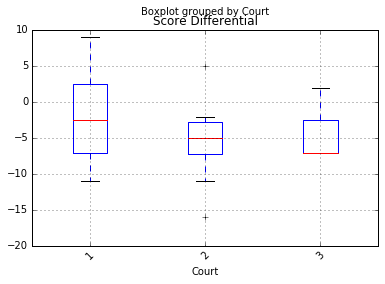

In [86]:
dfProcessed.boxplot(column=["Score Differential"], by="Court", rot=45)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D748B38>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000E7E9C88>], dtype=object)

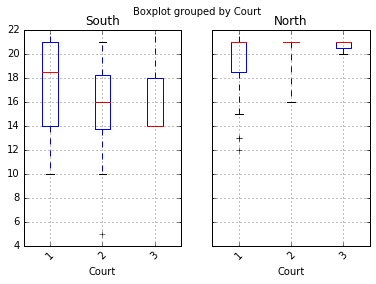

In [85]:
dfProcessed.boxplot(column=["South", "North"], by="Court", rot=45)

# Feature Engineering

In [9]:
def createPlayerDict(df):
    uniquePlayers = set(df["Player1"].tolist() +\
                    df["Player2"].tolist() +\
                    df["Player3"].tolist() +\
                    df["Player4"].tolist())
    
    uniquePlayersDict = dict(zip(uniquePlayers, range(len(uniquePlayers))))
    
    return uniquePlayersDict

playerDict = createPlayerDict(dfProcessed)
revPlayerDict = {v : k for k, v in playerDict.items()}

In [10]:
def teamToVector(teamSeries, playerDict):
    teamVector = np.zeros(len(playerDict))
    teamVector[playerDict[teamSeries[0]]] = 1
    teamVector[playerDict[teamSeries[1]]] = 1
    
    return teamVector

teamToVector(("ulric", "kurt"), playerDict)

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [32]:
playerComboList = [set(combo) for combo in itertools.combinations(playerDict.keys(), 2)]
interactionDict = {tuple(combo) : i for combo, i in zip(playerComboList, range(len(playerComboList)))}
revInteractionDict = {v : k for k, v in interactionDict.items()}

def createInteractionOnlyVector(teamTuple, interactionDict):
    intVector = np.zeros(len(interactionDict))
    
    if teamTuple == ("carmen", "ulric"):
        assert False
        
    if interactionDict.get(teamTuple):
        intVector[interactionDict.get(teamTuple)] = 1.0
    elif interactionDict.get((teamTuple[1], teamTuple[0])):
        intVector[interactionDict.get((teamTuple[1], teamTuple[0]))] = 1.0
    
    return intVector

In [31]:
def engFeatures(df, playerDictionary):
    dfFeatures = df.copy()
    
    dfFeatures["team1Names"] = dfFeatures.loc[:, ["Player1", "Player2"]].apply(lambda x: (x[0], x[1]), axis="columns")
    dfFeatures["team2Names"] = dfFeatures.loc[:, ["Player3", "Player4"]].apply(lambda x: (x[0], x[1]), axis="columns")
    
    dfFeatures["team1Vector"] = dfFeatures["team1Names"].apply(lambda x: teamToVector(x, playerDictionary))
    dfFeatures["team2Vector"] = dfFeatures["team2Names"].apply(lambda x: teamToVector(x, playerDictionary))
    dfFeatures["team1IntVector"] = dfFeatures["team1Names"].apply(lambda x: createInteractionOnlyVector(x, 
                                                                                         interactionDict))
    dfFeatures["team2IntVector"] = dfFeatures["team2Names"].apply(lambda x: createInteractionOnlyVector(x, 
                                                                                         interactionDict))
    
#     dfFeatures.drop(["Player1", "Player2", "Player3", "Player4"], axis="columns", inplace=True)
                                             
    return dfFeatures
    
dfFeatures = engFeatures(dfProcessed, playerDict)

In [55]:
dfFeatures.columns

Index(['Date', 'Court', 'Player1', 'Player2', 'Player3', 'Player4', 'South',
       'North', 'Score Differential', 'Win', 'team1Names', 'team2Names',
       'team1Vector', 'team2Vector', 'team1IntVector', 'team2IntVector'],
      dtype='object')

In [131]:
def stackTeamStats(df):
    dfTeam1 = pd.concat([df.loc[:, ["Player1",
                                    "Court",         
                                    "team1Names",
                                    "team1Vector",
                                    "team1IntVector",
                                    "Score Differential", 
                                    "South"]].rename(columns={"Player1" : "Player",
                                                              "team1Vector" : "teamVector",
                                                              "team1Names" : "teamNames",
                                                              "team1IntVector" : "teamIntVector",
                                                                "South" : "Score"}),
                            df.loc[:, ["Player2",
                                       "Court",
                                       "team1Names",
                                       "team1Vector",
                                       "team1IntVector",
                                       "Score Differential", 
                                       "South"]].rename(columns={"Player2" : "Player",
                                                                 "team1Vector" : "teamVector",
                                                                 "team1Names" : "teamNames",
                                                                 "team1IntVector" : "teamIntVector",
                                                                "South" : "Score"})])
    dfTeam1["Side"] = 1
    dfTeam2 = pd.concat([df.loc[:, ["Player3",
                                    "Court",
                                    "team2Names",
                                    "team2Vector",
                                    "team2IntVector",
                                    "Score Differential", 
                                    "North"]].rename(columns={"Player3" : "Player",
                                                              "team2Vector" : "teamVector",
                                                              "team2Names" : "teamNames",
                                                              "team2IntVector" : "teamIntVector",
                                                                "North" : "Score"}),
                            df.loc[:, ["Player4",
                                       "Court",
                                       "team2Names",
                                       "team2Vector",
                                       "team2IntVector",
                                       "Score Differential", 
                                       "North"]].rename(columns={"Player4" : "Player",
                                                                 "team2Vector" : "teamVector",
                                                                 "team2Names" : "teamNames",
                                                                 "team2IntVector" : "teamIntVector",
                                                                "North" : "Score"})])
    dfTeam2["Score Differential"] = dfTeam2["Score Differential"] * -1
    dfTeam2["Side"] = 2
    
    dfStacked = pd.concat([dfTeam1, dfTeam2])
    dfStacked["Win"] = dfStacked["Score Differential"] > 0
    
    return dfStacked

# Descriptives

In [132]:
def getWinPercentage(df):    
    # Stack dataframe
    dfStacked = stackTeamStats(df)
    
    # Group and count
    dfGroupedPlayer = dfStacked.groupby(["Player"])
    dfWinPercentage = pd.concat([dfGroupedPlayer.count().reset_index().loc[:, ["Player", "Win"]].rename(columns={"Win": "Games Played"}),
                                dfGroupedPlayer.sum().reset_index().loc[:, ["Score Differential", "Win"]]
                                ], axis="columns")
    
    dfWinPercentage["Win %"] = dfWinPercentage["Win"] / dfWinPercentage["Games Played"].astype(float) * 100
    dfWinPercentage["Score Diff per Game"] = dfWinPercentage["Score Differential"] / dfWinPercentage["Games Played"].astype(float)
    
    return dfWinPercentage
          
dfWinPercentages = getWinPercentage(dfFeatures)
dfWinPercentages

,Player,Games Played,Score Differential,Win,Win %,Score Diff per Game
0,bri,8,-2,5.0,62.500000,-0.250000
1,bruce,4,-6,2.0,50.000000,-1.500000
2,carmen,3,13,2.0,66.666667,4.333333
3,frank,9,37,6.0,66.666667,4.111111
4,james,14,-28,7.0,50.000000,-2.000000
5,kurt,23,-57,6.0,26.086957,-2.478261
6,les,3,-12,1.0,33.333333,-4.000000
7,linh,17,19,10.0,58.823529,1.117647
8,maceo,12,33,10.0,83.333333,2.750000
9,russ,11,53,9.0,81.818182,4.818182


In [81]:
def getWinPercentageByCourt(df):    
    # Stack dataframe
    dfStacked = stackTeamStats(df)
    
    # Group and count
    dfGroupedPlayer = dfStacked.groupby(["Court"])
    dfWinPercentage = pd.concat([dfGroupedPlayer.count().reset_index().loc[:, ["Court",  
                                                                               "Win"]].rename(columns={"Win": "Games Played"}),
                                dfGroupedPlayer.sum().reset_index().loc[:, ["Score Differential", 
                                                                            "Win"]]
                                ], axis="columns")

    return dfWinPercentage
    dfWinPercentage["Win %"] = dfWinPercentage["Win"] / dfWinPercentage["Games Played"].astype(float) * 100
    dfWinPercentage["Score Diff per Game"] = dfWinPercentage["Score Differential"] / dfWinPercentage["Games Played"].astype(float)
    
    
dfWinsByCourt = getWinPercentageByCourt(dfFeatures)

groupByCourt = dfWinsByCourt.groupby("Court")
dfWinsByCourt = pd.concat([groupByCourt.count().reset_index().loc[:, ["Court", 
                                                                      "Win"]].rename(columns={"Win": "Games Played"}),
                            groupByCourt.sum().reset_index().loc[:, ["Score Differential", 
                                                                            "Win"]]
                                ], axis="columns")
dfWinsByCourt

,Court,Games Played,Score Differential,Win
0,1,1,0,48.0
1,2,1,0,16.0
2,3,1,0,6.0


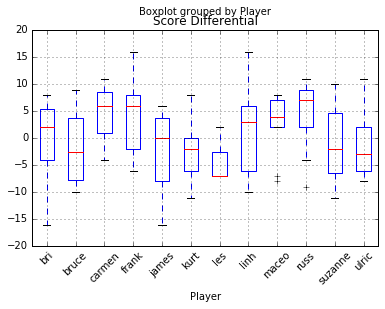

In [15]:
def boxPlots(df, playerList=None):
    
    dfPlotData = stackTeamStats(df)
    
    if playerList:
        playerFilter = dfFlattenedData["Player"].isin(playerList)
        dfPlotData = dfFlattenedData.loc[playerFilter]
    
    dfPlotData.boxplot(column="Score Differential", by="Player", rot=45)
        
boxPlots(dfFeatures)

# Model data

In [16]:
from sklearn import linear_model
import statsmodels.api as sm

### Simple model

First model each team's score as a function of the players on the team

$score = \sum^{k}_{i = 0} \beta_i player_i$

This model ignores: 
* interactions between players on the same team
* interactions with the opposing team

In [109]:
dfFeatures

,Date,Court,Player1,Player2,Player3,Player4,South,North,Score Differential,Win,team1Names,team2Names,team1Vector,team2Vector,team1IntVector,team2IntVector
0,2016-09-17,1,ulric,kurt,linh,james,15,21,-6,False,"(ulric, kurt)","(linh, james)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2016-09-17,1,kurt,suzanne,james,ulric,19,21,-2,False,"(kurt, suzanne)","(james, ulric)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2016-09-17,1,linh,kurt,suzanne,james,22,20,2,True,"(linh, kurt)","(suzanne, james)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2016-09-17,1,linh,ulric,suzanne,frank,21,15,6,True,"(linh, ulric)","(suzanne, frank)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2016-09-17,1,frank,ulric,kurt,james,17,21,-4,False,"(frank, ulric)","(kurt, james)","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,2016-09-17,1,linh,frank,suzanne,james,21,13,8,True,"(linh, frank)","(suzanne, james)","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,2016-09-17,1,linh,kurt,ulric,suzanne,21,17,4,True,"(linh, kurt)","(ulric, suzanne)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,2016-09-17,1,frank,suzanne,james,kurt,21,13,8,True,"(frank, suzanne)","(james, kurt)","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,2016-09-17,1,ulric,kurt,frank,suzanne,20,22,-2,False,"(ulric, kurt)","(frank, suzanne)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,2016-09-24,1,ulric,kurt,linh,james,16,21,-5,False,"(ulric, kurt)","(linh, james)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [114]:
def fitStatsModel(df, independentVars, dependentVar):
    dfStacked = stackTeamStats(df)
    
    # create design matrices
    dfX = dfStacked.loc[:, independentVars]
    X = np.vstack(dfX.values)
    Y = dfStacked.loc[:, [dependentVar]].values
    
    Xconstant = sm.add_constant(X)
    fittedModel = sm.OLS(Y, Xconstant, hasconst=None).fit()

    return fittedModel, dfStacked

smModel, smModelTrainingData = fitStatsModel(dfFeatures, "teamVector", "Score Differential")
smModel.summary(xname = ["Intercept"] + list(revPlayerDict.values()))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     6.184
Date:                Sun, 02 Oct 2016   Prob (F-statistic):           4.31e-08
Time:                        21:57:20   Log-Likelihood:                -434.25
No. Observations:                 140   AIC:                             892.5
Df Residuals:                     128   BIC:                             927.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.1787      0.527      0.339      0.735        -0.865     1.222
bri           -2.8932      1.582     -1.829      0.070        -6.024     0.237
bruce         -3.8673      2.005     -1.929      0.056        -7.834     0.099
james         -0.9986      1.257     -0.794      0.428        -3.486     1.489
frank          5.6931      1.496      3.804      0.000         2.732     8.654
ulric         -2.1189      0.993     -2.134      0.035        -4.084    -0.154
carmen         2.7182      2.385      1.140      0.256        -2.000     7.437
les           -4.5522      2.241     -2.031      0.044        -8.986    -0.118
suzanne       -2.8174      1.127     -2.500      0.014        -5.047    -0.588
russ           6.3065      1.321      4.773      0.000         3.692     8.921
maceo          5.0986      1.357      3.758      0.000         2.414     7.783
linh          -0.3520      1.119     -0.314      0.754        -2.567     1.863
kurt          -1.8594      0.959     -1.939      0.055        -3.757     0.038
==============================================================================
Omnibus:                       10.758   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.459
Skew:                          -0.700   Prob(JB):                      0.00325
Kurtosis:                       3.072   Cond. No.                     1.18e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.46e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [121]:
def predictOutcomes(model, data, independentVars, dependentVar):
    data["prediction"] = model.predict(sm.add_constant(np.vstack(data.loc[:, independentVars].values)))
    return data

dfSmPredicted = predictOutcomes(smModel, smModelTrainingData, independentVars = "teamVector", dependentVar = "Score Differential")
dfSmPredicted

,Player,Court,teamVector,teamIntVector,Score Differential,Score,Side,Win,prediction
0,ulric,1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-6,15,1,False,-3.799562
1,kurt,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-2,19,1,False,-4.498028
2,linh,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,22,1,True,-2.032647
3,linh,1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6,21,1,True,-2.292156
4,frank,1,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-4,17,1,False,3.752907
5,linh,1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8,21,1,True,5.519822
6,linh,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,21,1,True,-2.032647
7,frank,1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8,21,1,True,3.054441
8,ulric,1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-2,20,1,False,-3.799562
9,ulric,1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-5,16,1,False,-3.799562


# Scikit learn models

In [18]:
def fitSkLearnModel(df, independentVars, dependentVar):
    dfStacked = stackTeamStats(df)
    
    # create design matrices
    X = np.vstack(dfStacked.loc[:, independentVars].values)
    Y = dfStacked[dependentVar].values
    
    fittedModel = linear_model.LinearRegression()
    fittedModel.fit(X, Y)

    return fittedModel

lrModel = fitSkLearnModel(dfFeatures, "teamVector", "Score Differential")

In [19]:
def getModelParameters(model, playerDict, teamDict=None):
    results = {}
    results["intercept"] = model.intercept_
    results["coefficients"] = {}
    
    coefDict = playerDict.copy()
    if teamDict:
        coefDict.update({(k + len(playerDict)) : v for k, v in teamDict.items()})

    for position, value in enumerate(model.coef_):
        results["coefficients"][coefDict[position]] = value
    
    sortedCoefficients = sorted(results["coefficients"].items(), key=lambda x: -x[1])
    
    print("Intercept = %f" % results["intercept"])
    print("Coefficients:")
    for k,v in sortedCoefficients:
        if v != 0:
            print("%s = %f" % (k,v))
    
    return results

lrModelStats = getModelParameters(lrModel, revPlayerDict)

Intercept = 0.238292
Coefficients:
russ = 6.276731
frank = 5.663296
maceo = 5.068815
carmen = 2.688405
linh = -0.381767
james = -1.028412
kurt = -1.889173
ulric = -2.148682
suzanne = -2.847148
bri = -2.923017
bruce = -3.897103
les = -4.581946


In [20]:
# import sklearn.feature_selection

def getPvalues(model, debug=False):
    x = model.model.data.exog
    y = model.model.data.endog
    n, k = (x.shape[0], x.shape[1] - 1)
    df = float(n-k)
    yHat = model.predict(x)
    
#     return sklearn.feature_selection.f_regression(x[:,1:], y, center=False)
    
    
    # Sample variance.  
    residuals = y - yHat
#     residuals = model.resid
    sse = np.sum(np.square(residuals))
    sampleVariance = sse/df

    sampleVarianceX = np.matrix(np.matrix(x).T * np.matrix(x))
    
    # Covariance Matrix = [(s^2)(X'X)^-1]^0.5. (sqrtm = matrix square root.  ugly)
    covarianceMatrix = (sampleVariance*sampleVarianceX).I

    # Standard errors for the difference coefficients: the diagonal elements of the covariance matrix.
    se = scipy.linalg.sqrtm(covarianceMatrix).diagonal()
    
    # T statistic for each beta.
    betasTStat = np.zeros(len(se))
    for i in range(len(se)):
        betasTStat[i] = model.params[i]/se[i]

    # P-value for each beta. This is a two sided t-test, since the betas can be 
    # positive or negative.
    betasPValue = 1 - scipy.stats.t.cdf(abs(betasTStat),df)
    
    if debug:
        print("num obs = %i, num vars = %i, df = %i" % (n, k, df))
#         print(residuals)
        print("sse = %.3f" % sse)
        print("Covariance Matrix")
        print(covarianceMatrix)
        print("se")
        print(se)
        print("sample variance = %.3f" % sampleVariance)
        print("t stats:")
        print(betasTStat)
#         print("sample variance of x")
#         print(sampleVarianceX)
#         print("covariance matrix")
#         print(covarianceMatrix)
#         print(covarianceMatrix.shape)

    return betasPValue

getPvalues(smModel, debug=False)
# type(getPvalues(lrAllModel, Xall, Y))

C:\Users\uwong\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


array([ 0.49999996,  0.49999718,  0.49999623,  0.49999903,  0.49999445,
        0.49999793,  0.49999735,  0.49999556,  0.49999725,  0.49999385,
        0.49999503,  0.49999966,  0.49999819])

# Model Teams as interactions

In [23]:
def showRankedCoeffs(smModel, coefNames, significantOnly=False):
    coefList = list(zip(coefNames, smModel.params, smModel.pvalues))
    if significantOnly:
        coefList = [coef for coef in coefList if coef[2] < .05]
        
    sortedCoefList = sorted(coefList, key = lambda x:- x[1])
    
    dfResult = pd.DataFrame(sortedCoefList, columns=["coefficient", "value", "p-value"])
    return dfResult
    
showRankedCoeffs(smModel, ["Intercept"] + list(revPlayerDict.values()), significantOnly=True)

,coefficient,value,p-value
0,russ,6.306517,0.000005
1,frank,5.693083,0.000219
2,maceo,5.098602,0.000260
3,ulric,-2.118895,0.034759
4,suzanne,-2.817361,0.013671
5,les,-4.552159,0.044277


In [ ]:
sm.regression.linear_model.RegressionModel.

In [133]:
def dfFitInteractionOnlyModel(df, independentVars, dependentVar):
    dfStacked = stackTeamStats(df)    

    # create design matrices
    X = np.vstack(dfStacked.loc[:, independentVars].values)
    Y = dfStacked[dependentVar].values
    
    Xconstant = sm.add_constant(X, has_constant="add")
    fittedModel = sm.OLS(Y, Xconstant, hasconst=None).fit_regularized(alpha=.01)

    return fittedModel, dfStacked

smInteractionModel, smInteractionTrainingData = dfFitInteractionOnlyModel(dfFeatures, "teamIntVector", "Score Differential")
smInteractionModel.summary(xname = ["Intercept"] + list(revInteractionDict.values()))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     5.820
Date:                Sun, 02 Oct 2016   Prob (F-statistic):           2.46e-12
Time:                        22:09:25   Log-Likelihood:                -393.51
No. Observations:                 140   AIC:                             853.0
Df Residuals:                     107   BIC:                             950.1
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 0.3500      2.301      0.152      0.879        -4.211     4.911
('bruce', 'james')             0          0        nan        nan             0         0
('bruce', 'ulric')             0          0        nan        nan             0         0
('carmen', 'bruce')            0          0        nan        nan             0         0
('bruce', 'frank')        7.9500      3.985      1.995      0.049         0.051    15.849
('russ', 'bruce')         0.9500      3.985      0.238      0.812        -6.949     8.849
('bruce', 'les')               0          0        nan        nan             0         0
('suzanne', 'bruce')           0          0        nan        nan             0         0
('maceo', 'bruce')             0          0        nan        nan             0         0
('linh', 'bruce')        -9.6500      3.985     -2.422      0.017       -17.549    -1.751
('bri', 'bruce')         -6.6500      3.985     -1.669      0.098       -14.549     1.249
('kurt', 'bruce')              0          0        nan        nan             0         0
('james', 'ulric')        0.9500      3.985      0.238      0.812        -6.949     8.849
('carmen', 'james')       0.3000      3.253      0.092      0.927        -6.150     6.750
('james', 'frank')             0          0        nan        nan             0         0
('russ', 'james')              0          0        nan        nan             0         0
('les', 'james')               0          0        nan        nan             0         0
('suzanne', 'james')     -6.1167      2.970     -2.060      0.042       -12.004    -0.229
('maceo', 'james')             0          0        nan        nan             0         0
('linh', 'james')         4.0833      2.970      1.375      0.172        -1.804     9.971
('bri', 'james')        -15.6500      3.985     -3.928      0.000       -23.549    -7.751
('kurt', 'james')        -3.1750      2.818     -1.127      0.262        -8.760     2.410
('carmen', 'ulric')            0          0        nan        nan             0         0
('frank', 'ulric')       -3.6500      3.985     -0.916      0.362       -11.549     4.249
('russ', 'ulric')         5.8000      3.253      1.783      0.077        -0.650    12.250
('les', 'ulric')         -6.6500      3.985     -1.669      0.098       -14.549     1.249
('suzanne', 'ulric')     -6.0000      3.253     -1.844      0.068       -12.450     0.450
('maceo', 'ulric')        0.7500      2.970      0.253      0.801        -5.138     6.638
('linh', 'ulric')              0          0        nan        nan             0         0
('bri', 'ulric')         -2.6500      3.985     -0.665      0.507       -10.549     5.249
('kurt', 'ulric')        -3.9643      2.609     -1.520      0.132        -9.135     1.207
('carmen', 'frank')    

In [134]:
showRankedCoeffs(smInteractionModel, ["Intercept"] + list(revInteractionDict.values()), significantOnly=True)

,coefficient,value,p-value
0,"(carmen, russ)",9.950000,0.014045
1,"(russ, suzanne)",8.300000,0.012150
2,"(bruce, frank)",7.950000,0.048566
3,"(linh, frank)",6.475000,0.023501
4,"(suzanne, james)",-6.116666,0.041873
5,"(linh, bruce)",-9.650000,0.017125
6,"(bri, james)",-15.650000,0.000152


In [135]:
def predictOutcomes(model, data, independentVars, dependentVar):
    data["prediction"] = model.predict(sm.add_constant(np.vstack(data.loc[:, independentVars].values), 
                                                       has_constant="add"))
    return data

dfSmIntPredicted = predictOutcomes(smInteractionModel, 
                                smInteractionTrainingData, 
                                   independentVars = "teamIntVector", 
                                   dependentVar = "Score Differential")
dfSmIntPredicted

,Player,Court,teamNames,teamVector,teamIntVector,Score Differential,Score,Side,Win,prediction
0,ulric,1,"(ulric, kurt)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-6,15,1,False,-3.614286
1,kurt,1,"(kurt, suzanne)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-2,19,1,False,-4.825000
2,linh,1,"(linh, kurt)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,22,1,True,-0.575000
3,linh,1,"(linh, ulric)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6,21,1,True,0.350000
4,frank,1,"(frank, ulric)","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-4,17,1,False,-3.300000
5,linh,1,"(linh, frank)","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8,21,1,True,6.825000
6,linh,1,"(linh, kurt)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,21,1,True,-0.575000
7,frank,1,"(frank, suzanne)","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8,21,1,True,1.100000
8,ulric,1,"(ulric, kurt)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-2,20,1,False,-3.614286
9,ulric,1,"(ulric, kurt)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-5,16,1,False,-3.614286


# Model main and interaction effects

In [161]:
np.vstack(stackTeamStats(dfFeatures).apply(lambda row: pd.Series(np.hstack([row["teamVector"], 
                                                 row["teamIntVector"]])), 
                                                 axis="columns").values)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [167]:
dfFeatures.columns

Index(['Date', 'Court', 'Player1', 'Player2', 'Player3', 'Player4', 'South',
       'North', 'Score Differential', 'Win', 'team1Names', 'team2Names',
       'team1Vector', 'team2Vector', 'team1IntVector', 'team2IntVector'],
      dtype='object')

In [168]:
def dfFitMainInteractionModel(df, mainColumn, interactionColumn, dependentVar, playerDict, interactionDict):
    dfStacked = stackTeamStats(df) 
    dfAll = dfStacked.apply(lambda row: pd.Series(np.hstack([row[mainColumn], 
                                                 row[interactionColumn]])), 
                axis="columns")

    # create design matrices
    X = np.vstack((dfAll.values))
    Y = dfStacked[dependentVar].values
    
    Xconstant = sm.add_constant(X, has_constant="add")
    fittedModel = sm.OLS(Y, Xconstant, hasconst=None).fit_regularized(L1_wt=0.5, alpha=.001)

    return fittedModel, dfAll

smMainInteractionModel, smMainIntTrainingData = dfFitMainInteractionModel(dfFeatures, 
                                                   "teamVector",                                                    
                                                   "teamIntVector",                       
                                                   "Score Differential", 
                                                   playerDict,
                                                   interactionDict)
# smMainInteractionModel.summary()
smMainInteractionModel.summary(xname = ["Intercept"] + list(revPlayerDict.values()) + list(revInteractionDict.values()))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     5.900
Date:                Sun, 02 Oct 2016   Prob (F-statistic):           1.66e-12
Time:                        22:30:03   Log-Likelihood:                -392.91
No. Observations:                 140   AIC:                             851.8
Df Residuals:                     107   BIC:                             948.9
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                -0.3202      0.431     -0.743      0.459        -1.175     0.534
bri                      -2.5661      1.129     -2.273      0.025        -4.804    -0.328
bruce                    -2.2926      1.252     -1.831      0.070        -4.775     0.190
james                    -1.3424      1.049     -1.280      0.203        -3.421     0.736
frank                     3.9737      1.054      3.771      0.000         1.885     6.063
ulric                    -1.3485      0.810     -1.665      0.099        -2.954     0.257
carmen                    2.6643      2.124      1.255      0.212        -1.546     6.874
les                      -2.9805      1.351     -2.206      0.030        -5.659    -0.302
suzanne                  -1.3836      0.793     -1.745      0.084        -2.956     0.189
russ                      5.7592      0.976      5.900      0.000         3.824     7.694
maceo                     3.7019      0.956      3.874      0.000         1.807     5.596
linh                     -1.3115      0.841     -1.559      0.122        -2.979     0.356
kurt                     -1.3345      1.071     -1.246      0.215        -3.458     0.788
('bruce', 'james')             0          0        nan        nan             0         0
('bruce', 'ulric')             0          0        nan        nan             0         0
('carmen', 'bruce')            0          0        nan        nan             0         0
('bruce', 'frank')        7.3470      2.366      3.106      0.002         2.657    12.037
('russ', 'bruce')        -1.0738      2.479     -0.433      0.666        -5.989     3.841
('bruce', 'les')               0          0        nan        nan             0         0
('suzanne', 'bruce')           0          0        nan        nan             0         0
('maceo', 'bruce')             0          0        nan        nan             0         0
('linh', 'bruce')        -5.8364      2.483     -2.351      0.021       -10.758    -0.915
('bri', 'bruce')         -1.7258      2.457     -0.702      0.484        -6.597     3.145
('kurt', 'bruce')              0          0        nan        nan             0         0
('james', 'ulric')        4.8078      2.893      1.662      0.099        -0.927    10.543
('carmen', 'james')            0          0        nan        nan             0         0
('james', 'frank')             0          0        nan        nan             0         0
('russ', 'james')              0          0        nan        nan             0         0
('les', 'james')               0          0        nan        nan             0         0
('suzanne', 'james')     -2.9083      1.814     -1.603      0.112        -6.505     0.688
('maceo', 'james')             0          0        nan        nan             0         0
('linh', 'james')      

In [169]:
showRankedCoeffs(smMainInteractionModel, 
                 ["Intercept"] + list(revPlayerDict.values()) + list(revInteractionDict.values()), 
                 significantOnly=True)

,coefficient,value,p-value
0,"(linh, james)",7.541130,1.114710e-04
1,"(bruce, frank)",7.346964,2.430784e-03
2,russ,5.759158,4.323771e-08
3,"(russ, suzanne)",4.842354,1.560179e-02
4,"(linh, frank)",4.608968,3.076934e-03
5,frank,3.973668,2.669685e-04
6,maceo,3.701906,1.849685e-04
7,"(bri, maceo)",3.395866,4.735200e-02
8,bri,-2.566065,2.503600e-02
9,les,-2.980495,2.952673e-02


In [170]:
smInteractionTrainingData

,Player,Court,teamNames,teamVector,teamIntVector,Score Differential,Score,Side,Win,prediction
0,ulric,1,"(ulric, kurt)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-6,15,1,False,-3.614286
1,kurt,1,"(kurt, suzanne)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-2,19,1,False,-4.825000
2,linh,1,"(linh, kurt)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,22,1,True,-0.575000
3,linh,1,"(linh, ulric)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6,21,1,True,0.350000
4,frank,1,"(frank, ulric)","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-4,17,1,False,-3.300000
5,linh,1,"(linh, frank)","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8,21,1,True,6.825000
6,linh,1,"(linh, kurt)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,21,1,True,-0.575000
7,frank,1,"(frank, suzanne)","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8,21,1,True,1.100000
8,ulric,1,"(ulric, kurt)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-2,20,1,False,-3.614286
9,ulric,1,"(ulric, kurt)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-5,16,1,False,-3.614286


In [ ]:
def predictOutcomes(model, data, independentVars, dependentVar):
    data["prediction"] = model.predict(sm.add_constant(np.vstack(data.loc[:, independentVars].values), 
                                                       has_constant="add"))
    return data

dfSmIntPredicted = predictOutcomes(smInteractionModel, 
                                smInteractionTrainingData, 
                                   independentVars = "teamIntVector", 
                                   dependentVar = "Score Differential")
dfSmIntPredicted